In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)
This code need to run in Spark enviorment.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [3]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [6]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [7]:
movies.show(10)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
 6| Heat (1995)|Action|Crime|Thri...|
 7| Sabrina (1995)| Comedy|Romance|
 8| Tom and Huck (1995)| Adventure|Children|
 9| Sudden Death (1995)| Action|
 10| GoldenEye (1995)|Action|Adventure|...|
+-------+--------------------+--------------------+
only showing top 10 rows

In [8]:
ratings.show(10)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
 1| 70| 3.0|964982400|
 1| 101| 5.0|964980868|
 1| 110| 4.0|964982176|
 1| 151| 5.0|964984041|
 1| 157| 5.0|964984100|
+------+-------+------+---------+
only showing top 10 rows

In [9]:
tags.show()

+------+-------+-----------------+----------+
userId|movieId| tag| timestamp|
+------+-------+-----------------+----------+
 2| 60756| funny|1445714994|
 2| 60756| Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
 2| 89774| Tom Hardy|1445715205|
 2| 106782| drugs|1445715054|
 2| 106782|Leonardo DiCaprio|1445715051|
 2| 106782| Martin Scorsese|1445715056|
 7| 48516| way too long|1169687325|
 18| 431| Al Pacino|1462138765|
 18| 431| gangster|1462138749|
 18| 431| mafia|1462138755|
 18| 1221| Al Pacino|1461699306|
 18| 1221| Mafia|1461699303|
 18| 5995| holocaust|1455735472|
 18| 5995| true story|1455735479|
 18| 44665| twist ending|1456948283|
 18| 52604| Anthony Hopkins|1457650696|
 18| 52604| courtroom drama|1457650711|
+------+-------+-----------------+----------+
only showing top 20 rows

In [10]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [11]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: Spark SQL and OLAP

In [13]:
#To figured out how many users in the dataset
num_users=ratings.select('userId').distinct().count()
print ('There are {} users in rating table'.format(num_users))

There are 610 users in rating table

In [14]:
#To find out how may movies in the dataset
num_movies=movies.select('movieId').distinct().count()
print ('There are {} movies in movies table'.format(num_movies))

There are 9742 movies in movies table

Cause number of movies is much more than the number of users, so maybe apply user-based model is more efficeint than item-based.

To find out how many movies are rated by users and any movies not rated before

In [17]:

ratings.createOrReplaceTempView("rat")
movies_rated=spark.sql("select count(movieId) from rat where rating==0 ")
#display(movies_rated)
movies_rated=sum(ratings.groupby('rating').count().toPandas()['count']==0)
print ('There are {} movies not rated before'.format(movies_rated))

There are 0 movies not rated before

To find out how many genres totally

In [19]:
genres_num=movies.select('genres').distinct().count()
genres=movies.select('genres')
#genres.show()
print('There are {} genres in movies table'.format(genres_num))

There are 951 genres in movies table

To find out how many movies in each genre

In [21]:
movies_num_genres=movies.groupBy('genres').count().orderBy('count', ascending=False)
movies_num_genres.show()

+--------------------+-----+
 genres|count|
+--------------------+-----+
 Drama| 1053|
 Comedy| 946|
 Comedy|Drama| 435|
 Comedy|Romance| 363|
 Drama|Romance| 349|
 Documentary| 339|
Comedy|Drama|Romance| 276|
 Drama|Thriller| 168|
 Horror| 167|
 Horror|Thriller| 135|
 Crime|Drama| 134|
Crime|Drama|Thriller| 125|
 Drama|War| 114|
 Comedy|Crime| 101|
 Action|Comedy| 92|
 Thriller| 84|
 Children|Comedy| 74|
 Comedy|Horror| 69|
Action|Adventure|...| 66|
Action|Crime|Thri...| 66|
+--------------------+-----+
only showing top 20 rows

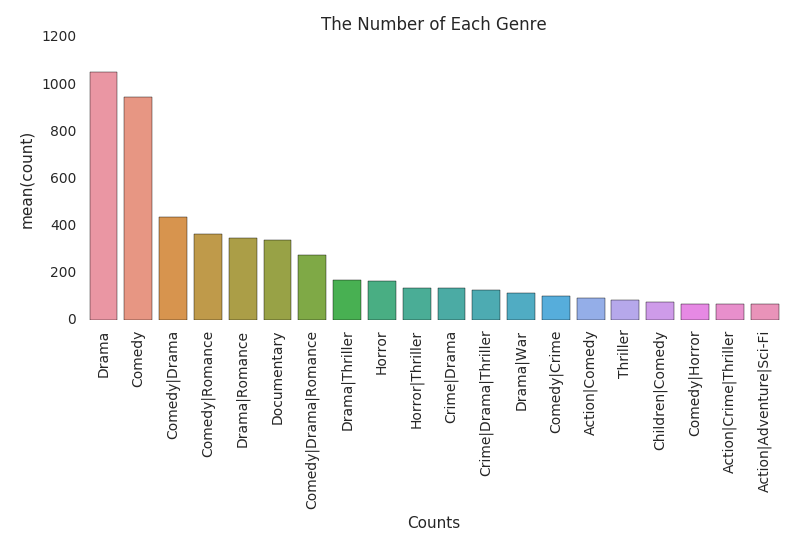

In [22]:
fig, axes = plt.subplots(1,1)
genres_count = movies_num_genres.toPandas()
genres_count=genres_count[:20]
sns.barplot(y="count", x="genres",data=genres_count,ax=axes)
plt.xlabel("Counts")
plt.title("The Number of Each Genre")
plt.xticks(rotation=90)
plt.tight_layout()
display(fig.show())

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [24]:
#from pyspark.ml.recommendation import ALS
from pyspark.mllib.recommendation import ALS
from pyspark.sql import Row

In [25]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

ratings = ratings.select("userId", "movieId", "rating")
# inspect the schema 
ratings.printSchema()

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- rating: string (nullable = true)

In [26]:
data_rating = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
# inspect the schema 
data_rating.printSchema()

root
-- userId: integer (nullable = true)
-- movieId: integer (nullable = true)
-- rating: float (nullable = true)

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [28]:
train, validation, test = data_rating.randomSplit([0.6,0.2,0.2],seed = 1)
print ("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 60567, 20061, 20208

In [29]:
train.cache()

Out[ 29 ]: DataFrame[userId: int, movieId: int, rating: float]

In [30]:
validation.cache()

Out[ 30 ]: DataFrame[userId: int, movieId: int, rating: float]

In [31]:
test.cache()

Out[ 31 ]: DataFrame[userId: int, movieId: int, rating: float]

Applied mean value of each movie as the prediction, and then we could compare the model performance between the mean-value model and the collaborative-fitering model accoring to Root Mean Square Erroe(rmse).

In [33]:
mean_rating=train.groupby('movieId').mean().select('movieId','avg(rating)')
mean_rating = mean_rating.withColumnRenamed('avg(rating)','prediction')
mean_rating.count()
display(mean_rating)

movieId,prediction
2366,3.764705882352941
1088,3.46
1580,3.442857142857143
32460,4.0
44022,3.4583333333333335
96488,4.333333333333333
1238,3.9375
1591,2.6176470588235294
1645,3.4393939393939394
3175,3.5106382978723403


We could join the train table with test table on same movieId, and then caculate RMSE of the test data set

In [35]:
test.createOrReplaceTempView("test")
mean_rating.createOrReplaceTempView("mean_rating")

sqlDF = spark.sql("select test.*, mean_rating.prediction \
                   from test join mean_rating \
                   on test.movieId = mean_rating.movieId")
display(sqlDF)
sqlDF.count()

userId,movieId,rating,prediction
493,2366,2.0,3.764705882352941
448,2366,5.0,3.764705882352941
39,2366,5.0,3.764705882352941
600,1088,3.5,3.46
583,1088,3.5,3.46
221,1088,3.0,3.46
200,1088,4.0,3.46
132,1088,4.0,3.46
104,1088,3.0,3.46
51,1088,4.0,3.46


In [36]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
def RMSE(predictions):
    return evaluator.evaluate(predictions)

In [37]:
print ('Using the mean rating of each movie as the prediction, the testing RMSE is ' + str(RMSE(sqlDF)))

Using the mean rating of each movie as the prediction, the testing RMSE is 0.9684681096936459

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [39]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_rmse = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # make prediction
            # get the rating result
            # get the RMSE
            als = ALS(rank = rank, 
                      maxIter = num_iterations, 
                      seed = 1, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop") 
            #error = None
            model = als.fit(train)
            predictions = model.transform(validation_data)
            #evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",predictionCol="prediction")
            rmse = RMSE(predictions)
            
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_rmse:
                min_rmse = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    print ('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [40]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9766416162998439
6 latent factors and regularization = 0.1: validation RMSE is 0.9124975447342438
6 latent factors and regularization = 0.2: validation RMSE is 0.8937841733801742
6 latent factors and regularization = 0.4: validation RMSE is 0.9626450319320567
6 latent factors and regularization = 0.8: validation RMSE is 1.1811223220496179
8 latent factors and regularization = 0.05: validation RMSE is 0.9939192808387594
8 latent factors and regularization = 0.1: validation RMSE is 0.916835902626747
8 latent factors and regularization = 0.2: validation RMSE is 0.8946289005096189
8 latent factors and regularization = 0.4: validation RMSE is 0.9624533854803139
8 latent factors and regularization = 0.8: validation RMSE is 1.181089011676798
10 latent factors and regularization = 0.05: validation RMSE is 1.0000582726052745
10 latent factors and regularization = 0.1: validation RMSE is 0.919667470168828
10 latent factors and regularization = 0.2: validation RMSE is 0.8963509045007014
10 latent factors and regularization = 0.4: validation RMSE is 0.9625753196982239
10 latent factors and regularization = 0.8: validation RMSE is 1.1811131335784153
12 latent factors and regularization = 0.05: validation RMSE is 1.0087194992127675
12 latent factors and regularization = 0.1: validation RMSE is 0.9162178021866768
12 latent factors and regularization = 0.2: validation RMSE is 0.894727484888669
12 latent factors and regularization = 0.4: validation RMSE is 0.9628509915478566
12 latent factors and regularization = 0.8: validation RMSE is 1.1810974954336622
14 latent factors and regularization = 0.05: validation RMSE is 1.0147499730431686
14 latent factors and regularization = 0.1: validation RMSE is 0.9187622802761995
14 latent factors and regularization = 0.2: validation RMSE is 0.8952361734207187
14 latent factors and regularization = 0.4: validation RMSE is 0.9628224519860767
14 latent factors and regularization = 0.8: validation RMSE is 1.1811107621037311
traning RMSE is 0.6894984317476609; validation RMSE is 0.8937841733801742

The best model has 6 latent factors and regularization = 0.2
Total Runtime: 670.27 seconds

Select 3 numbers according to last model traing result and then Gradient Search again to find out the best hyper-parameter

In [42]:
num_iterations = 20
ranks = [5, 6, 7]
reg_params = [0.1, 0.2, 0.3]

final_model=train_ALS(train, validation, num_iterations, reg_params, ranks)

5 latent factors and regularization = 0.1: validation RMSE is 0.912991014669153
5 latent factors and regularization = 0.2: validation RMSE is 0.8959979908871762
5 latent factors and regularization = 0.3: validation RMSE is 0.9214842302271261
6 latent factors and regularization = 0.1: validation RMSE is 0.911184988997912
6 latent factors and regularization = 0.2: validation RMSE is 0.8944181771079912
6 latent factors and regularization = 0.3: validation RMSE is 0.9211817900185335
7 latent factors and regularization = 0.1: validation RMSE is 0.9112996472460129
7 latent factors and regularization = 0.2: validation RMSE is 0.8951044358540294
7 latent factors and regularization = 0.3: validation RMSE is 0.9214938981221121
traning RMSE is 0.6853796706283821; validation RMSE is 0.8944181771079912

The best model has 6 latent factors and regularization = 0.2

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [44]:
pred_test = final_model.transform(test)
print ('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.8884978333224407

According to the RMSE result comparsion between Mean-Value model (0.9684681096936459) and Collaborative-Fitering model (0.8884978333224407), we could see that although the result may not cause hug improvement, the data is limited, and I believe in real-world with huge amount data, the Collaborative-Fitering model could performe much better.